In [41]:
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

#### Read data

In [2]:
%%time
# Read the data into a DataFrame
emails_df = pd.read_csv('data/emails.csv')

print(emails_df.shape)
# emails_df = emails_df_full.head(1000)

(517401, 2)
CPU times: user 23.8 s, sys: 1.99 s, total: 25.7 s
Wall time: 25.7 s


In [3]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [4]:
%%time
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

CPU times: user 3min 44s, sys: 3.26 s, total: 3min 47s
Wall time: 3min 47s


,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


#### Preprocess

In [5]:
%%time
# Set index and drop columns with few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

CPU times: user 6min 40s, sys: 52.4 ms, total: 6min 40s
Wall time: 6min 40s


Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [6]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [7]:
%%time
analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
sub_df=analysis_df.sample(1000)

CPU times: user 1.5 s, sys: 46 µs, total: 1.5 s
Wall time: 1.5 s


In [8]:
analysis_df.to_csv('data/parsed_df.csv', index=False)

#### dataset exploration

In [34]:
sub_df.content[4]

'I will plan to attend.  Can you attend as well?  --Sally \n---------------------- Forwarded by Sally Beck/HOU/ECT on 03/27/2000 12:37 PM \n---------------------------\n\n\nElisabeth McCabe@ENRON\n03/22/2000 03:37 PM\nTo: Brian Redmond/HOU/ECT@ECT, Tom Shelton/HOU/ECT@ECT, Renee \nIngram/HOU/ECT@ECT, Billy Lemmons/Corp/Enron@ENRON, James I \nDucote/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, Brenda F Herod/HOU/ECT@ECT, \nLouise Kitchen/HOU/ECT@ECT, Valeria A Hope/HOU/ECT@ECT, Susan \nRunkel/HOU/ECT@ECT, Brad Blesie/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Dan \nLyons/HOU/ECT@ECT, Scott Neal/HOU/ECT@ECT, Shelly Mansfield/HOU/ECT@ECT, Max \nYzaguirre/NA/Enron@ENRON, John Enerson/HOU/ECT@ECT, Morris Richard \nClark/HOU/ECT@ECT, Shannon Bedrich/Corp/Enron@Enron\ncc: Katherine Benedict/HOU/ECT@ECT, Michelle Vitrella/HOU/ECT@ECT \nSubject: Vision and Values Meeting\n\nAn ENA Vision and Values committee meeting will be held on Thursday, March 30 \nat 2:30 p.m. in 47C2.  \n\nWe will review the internal c

In [31]:
# print(sub_df.content[460])

In [10]:
print(analysis_df[analysis_df.content.apply(lambda x: '\n\n' in x)].content.values[3])

Greg,

 How about either next Tuesday or Thursday?

Phillip


In [38]:
analysis_df.content.apply(lambda x: '\n\n'  in x).mean()

0.8611703327693175

####  more preprocessing

In [21]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ayd98/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
#sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]
for text in sub_df['content']:
    text_clean.append(clean(text).split())

In [30]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [25]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [122]:
analysis_df

,From,To,Date,content,clean_content
Message-ID,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,(phillip.allen@enron.com),(tim.belden@enron.com),2001-05-14 16:39:00-07:00,Here is our forecast\n\n,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 13:51:00-07:00,Traveling to have a business meeting takes the...,traveling business meeting takes fun trip espe...
<24216240.1075855687451.JavaMail.evans@thyme>,(phillip.allen@enron.com),(leah.arsdall@enron.com),2000-10-18 03:00:00-07:00,test successful. way to go!!!,test successful way go
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 06:13:00-07:00,"Randy,\n\n Can you send me a schedule of the s...",randy send schedule salary level everyone sche...
<30922949.1075863688243.JavaMail.evans@thyme>,(phillip.allen@enron.com),(greg.piper@enron.com),2000-08-31 05:07:00-07:00,Let's shoot for Tuesday at 11:45.,let shoot tuesday
...,...,...,...,...,...
<26807948.1075842029936.JavaMail.evans@thyme>,(john.zufferli@enron.com),(kori.loibl@enron.com),2001-11-28 13:30:11-08:00,This is a trade with OIL-SPEC-HEDGE-NG (John L...,trade oil spec hedge ng john lavorato book joh...
<25835861.1075842029959.JavaMail.evans@thyme>,(john.zufferli@enron.com),(john.lavorato@enron.com),2001-11-28 12:47:48-08:00,Some of my position is with the Alberta Term b...,position alberta term book send positions dire...
<28979867.1075842029988.JavaMail.evans@thyme>,(john.zufferli@enron.com),(dawn.doucet@enron.com),2001-11-28 07:20:00-08:00,2\n\n -----Original Message-----\nFrom: \tDouc...,original message doucet dawn sent wednesday no...


## Clustering works BAD

#### lda model

In [68]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [69]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
word2vec_embeddings = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [70]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(word2vec_embeddings)

In [71]:
wordvector_fit_2d = word2vec_embeddings.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

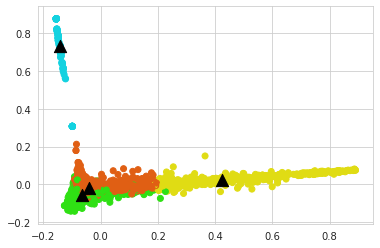

In [72]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [40]:
print(ldamodel.print_topics(num_topics=4, num_words=10))
# print([(0, '0.012*"enron" + 0.012*"deal" + 0.010*"agreement" + 0.008*"change" + 0.008*"contract" + 0.008*"corp" + 0.007*"fax" + 0.005*"houston" + 0.005*"date" + 0.005*"america"'), (1, '0.005*"message" + 0.005*"origin" + 0.004*"pleas" + 0.004*"email" + 0.004*"thank" + 0.003*"attach" + 0.003*"file" + 0.003*"copy" + 0.003*"inform" + 0.003*"receive"'), (2, '0.015*"thank" + 0.008*"call" + 0.005*"time" + 0.004*"meet" + 0.003*"look" + 0.003*"week" + 0.003*"day" + 0.003*"lunch" + 0.003*"talk" + 0.003*"hello"'), (3, '0.016*"market" + 0.009*"gas" + 0.008*"price" + 0.005*"power" + 0.004*"company" + 0.004*"energy" + 0.003*"business" + 0.003*"service" + 0.003*"manage" + 0.003*"fare"')])

[(0, '0.033*"com" + 0.011*"enron" + 0.010*"x" + 0.007*"e" + 0.006*"net" + 0.006*"www" + 0.006*"time" + 0.005*"asp" + 0.005*"travelocity" + 0.004*"image"'), (1, '0.010*"com" + 0.010*"enron" + 0.007*"ee" + 0.006*"td" + 0.006*"would" + 0.006*"pm" + 0.006*"image" + 0.005*"message" + 0.005*"data" + 0.005*"need"'), (2, '0.031*"enron" + 0.021*"ect" + 0.015*"com" + 0.011*"hou" + 0.006*"e" + 0.006*"company" + 0.006*"please" + 0.005*"million" + 0.005*"corp" + 0.005*"pm"'), (3, '0.031*"enron" + 0.028*"ect" + 0.012*"hou" + 0.006*"court" + 0.005*"schedule" + 0.005*"ee" + 0.005*"mark" + 0.005*"corp" + 0.004*"pm" + 0.004*"final"')]


#### find best cluster number

'forecast'

In [73]:
bow = CountVectorizer()

In [74]:
bow_embeddings = bow.fit_transform(short_analysis.clean_content)

In [75]:
bow_embeddings[0]

<1x44570 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [ ]:
# text_embeddings = bow.fit_transform([' '.join(text) for text in document_key_texts])

BOW embeddings

In [77]:
models = {}
silhouette_scores = []
i = 0
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k,  random_state=1).fit(bow_embeddings)
    score = silhouette_score(bow_embeddings, kmeans.labels_)
    silhouette_scores.append(score)

    i += 1
    models[score] = kmeans
_model = models[max(models)]

KeyboardInterrupt: 

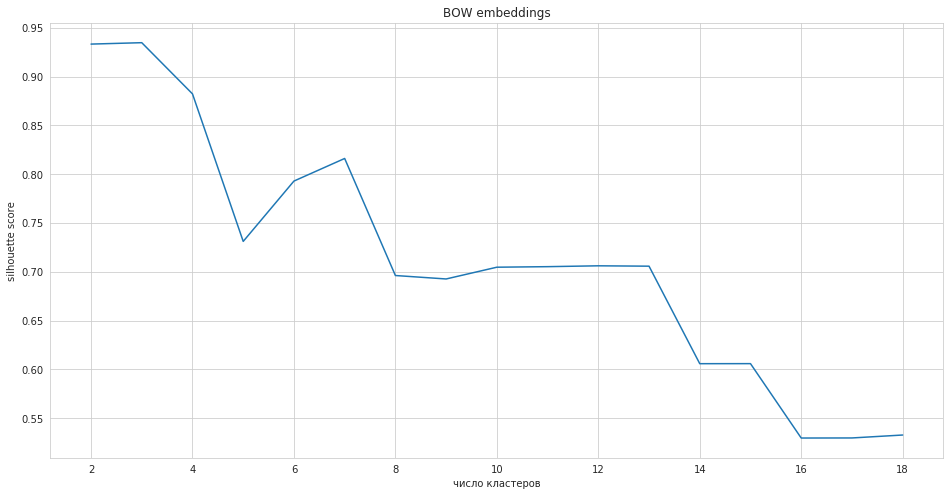

In [88]:
plt.figure(figsize=(16,8))
plt.title('BOW embeddings')
plt.xlabel('число кластеров')
plt.ylabel('silhouette score')
plt.plot(range(2, len(models)+2), list(models.keys()))
plt.show()

Tf-idf embeddings

In [120]:
models1 = {}
silhouette_scores1 = []

for k in range(10, 15):
    kmeans = KMeans(n_clusters=k,  random_state=1, max_iter=50).fit(word2vec_embeddings)
    score = silhouette_score(word2vec_embeddings, kmeans.labels_)
    silhouette_scores.append(score)

    models1[score] = kmeans
_model1 = models1[max(models1)]

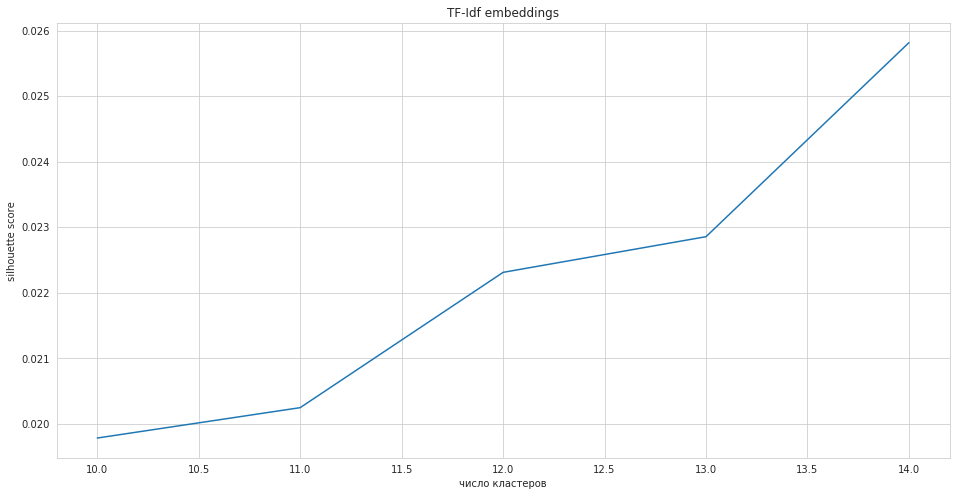

In [124]:
plt.figure(figsize=(16,8))
plt.title('TF-Idf embeddings')
plt.xlabel('число кластеров')
plt.ylabel('silhouette score')
plt.plot(range(10, 15), list(models1.keys()))
plt.show()

#### visualize

In [104]:
from collections import Counter

In [109]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters,  random_state=1)
labels = kmeans.fit_predict(bow_embeddings)

In [110]:
Counter(labels)

Counter({1: 4981, 0: 13, 2: 6})

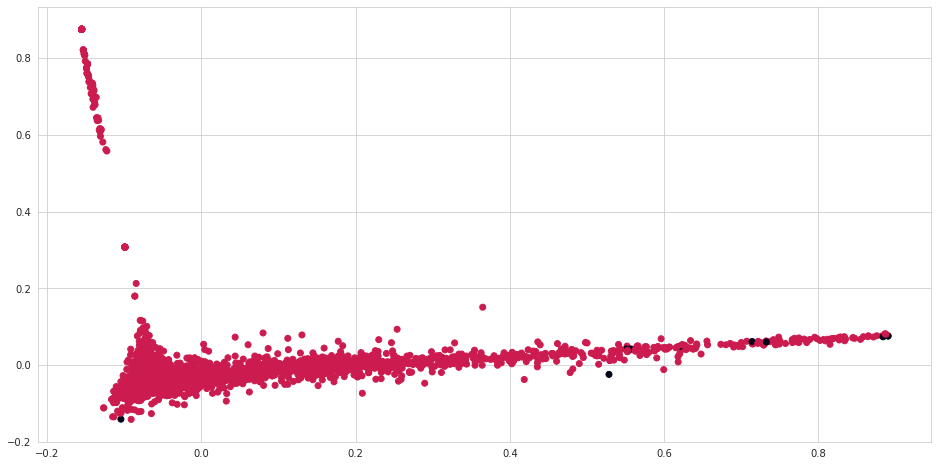

In [111]:
plt.figure(figsize=(16,8))
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

plt.show()

In [117]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters,  random_state=1, max_iter=50, init='k-means++', n_init=1)
labels = kmeans.fit_predict(word2vec_embeddings)
Counter(labels)

Counter({1: 3582, 2: 127, 3: 508, 0: 783})

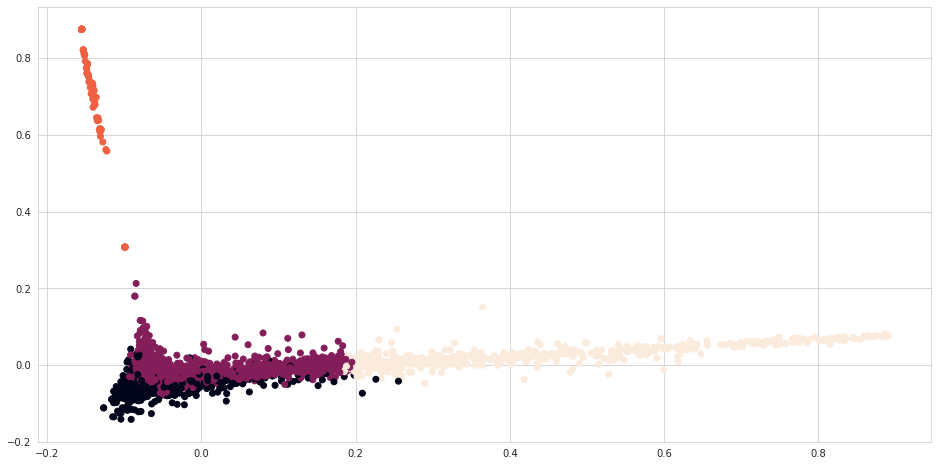

In [118]:
plt.figure(figsize=(16,8))
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

plt.show()

In [119]:
score = silhouette_score(word2vec_embeddings, kmeans.labels_)
score

0.022135586626379166